# AVIRIS-NG Methane Mapping

ESE 156 -- Christian Frankenberg
---
Task: -- Find the methane plume!

In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *

import os
import spectral.io.envi as envi

figsize(10,8)

In [2]:
from spectral import *

In [3]:
# Return the header associated with an image file (HDR datasets, all AVIRIS-like)
def find_header(imgfile):
  if os.path.exists(imgfile+'.hdr'):
    return imgfile+'.hdr'
  ind = imgfile.rfind('.raw')
  if ind >= 0:
    return imgfile[0:ind]+'.hdr'
  ind = imgfile.rfind('.img')
  if ind >= 0:
    return imgfile[0:ind]+'.hdr'
  raise IOError('No header found for file {0}'.format(imgfile));

In [4]:
# You can download all files from ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/AVng/
in_file = 'files/ang20150422t162859_rdn_v1f_clip'
in_hdr = find_header(in_file)
img = envi.open(in_hdr, in_file)
wl = np.loadtxt('files/ANGv3_spc_rev_300nm_truncated.wav')
# Color indices for R,G and B
index_r = np.argmin(np.abs(wl[:,1]-0.65))
index_g = np.argmin(np.abs(wl[:,1]-0.473))
index_b = np.argmin(np.abs(wl[:,1]-0.532))
#print index_r,index_g,index_b

In [5]:
print(img.shape)
rgb = img[:,:,[index_r,index_g,index_b]]
print(rgb.shape)

(3569, 598, 432)
(3569, 598, 3)


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [1.6666837930679321, 21.140193939208984]
    G: [2.3785924911499023, 18.134843826293945]
    B: [2.1339809894561768, 20.632106781005859]

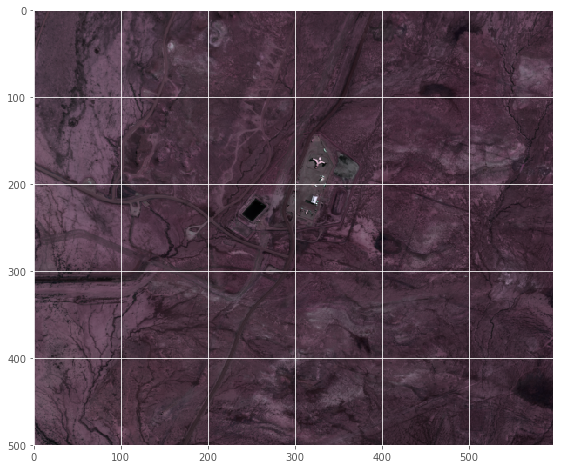

In [74]:

imshow(rgb[2000:2500,:,:])

(0, 1)

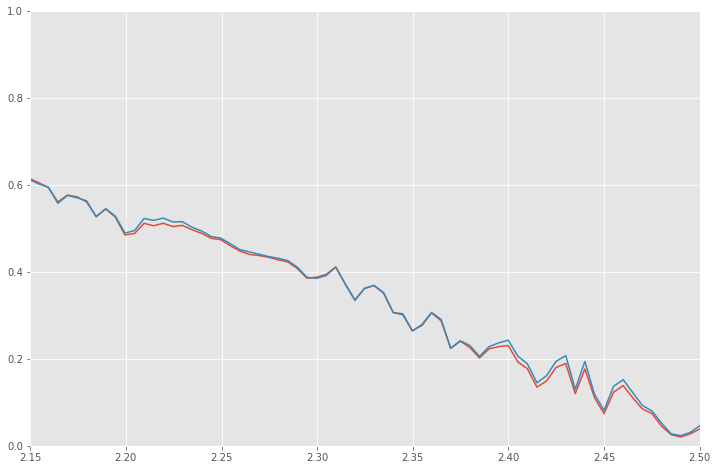

In [40]:
figsize(12,8)
ch4_rad=img[1000,500,:].flatten()
ch4_rad2=img[1500,300,:].flatten()
plt.plot(wl[:,1], ch4_rad)
plt.plot(wl[:,1], ch4_rad2)
plt.xlim((2.150,2.500))
plt.ylim((0,1))

(0.2, 0.45)

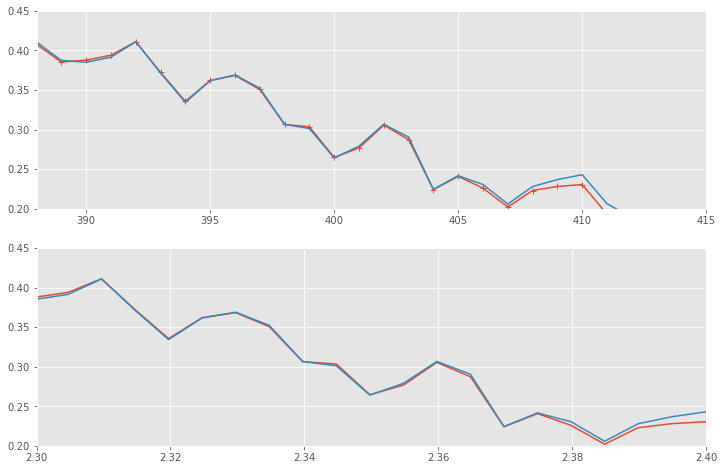

In [88]:
figsize(12,8)
plt.subplot(211)
ch4_rad=img[1000,500,:].flatten()
ch4_rad2=img[1500,300,:].flatten()
plt.plot(ch4_rad,'+-')
plt.plot(ch4_rad2)
plt.xlim((388,415))
plt.ylim((0.2,0.45))
plt.subplot(212)
plt.plot(wl[:,1], ch4_rad)
plt.plot(wl[:,1], ch4_rad2)
plt.xlim((2.30,2.400))
plt.ylim((0.2,0.45))

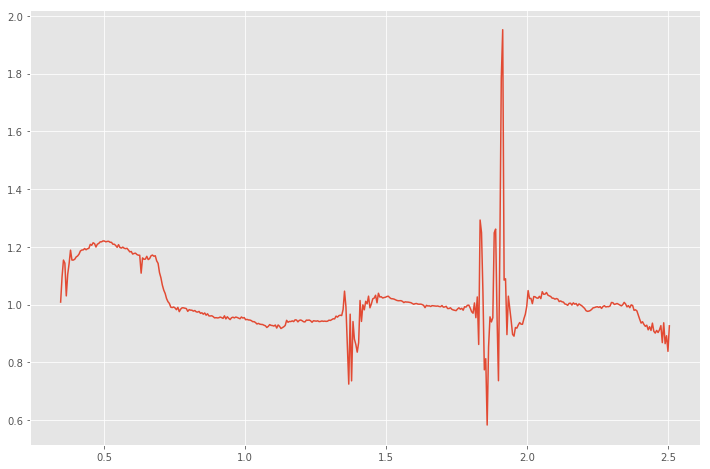

In [23]:
plt.plot(wl[:,1], ch4_rad/ch4_rad2)

In [8]:
from hapi import *

HAPI version: 1.1.0.8.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [9]:
xmin = 1e7/2500
xmax = 1e7/400
storage2cache('CO2_av')
storage2cache('CH4_av')
storage2cache('H2O_av')
#fetch('CO2_av',2,1,xmin,xmax);
#fetch('CH4_av',6,1,xmin,xmax);
#fetch('H2O_av',1,1,xmin,xmax);

                     Lines parsed: 68605
                     Lines parsed: 174475
                     Lines parsed: 111528


In [10]:
p = 850.0
T = 290.0

nu_, cs_co2 = absorptionCoefficient_Voigt(SourceTables='CO2_av',WavenumberStep=0.01, WavenumberRange=[xmin,1e7/350],Environment={'p':p/1013,'T':T})
nu_, cs_ch4 = absorptionCoefficient_Voigt(SourceTables='CH4_av',WavenumberStep=0.01, WavenumberRange=[xmin,1e7/350],Environment={'p':p/1013,'T':T})
nu_, cs_h2o = absorptionCoefficient_Voigt(SourceTables='H2O_av',WavenumberStep=0.01, WavenumberRange=[xmin,1e7/350],Environment={'p':p/1013,'T':T})

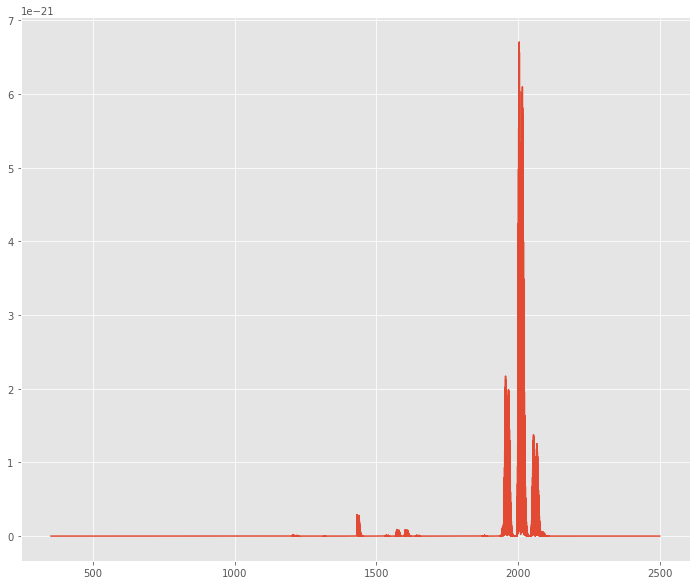

In [13]:
vcd_co2 = 8e21;
vcd_ch4 = 4e19;
vcd_h2o = 5e22;

wl_hr = np.arange(351,2500,0.01)
wl_lr = wl[5:-2,1]*1e3

fco2 = interp1d(1e7/nu_, cs_co2,kind='linear')
cs_co2_wl = fco2(wl_hr);
fch4 = interp1d(1e7/nu_, cs_ch4,kind='linear')
cs_ch4_wl = fch4(wl_hr);
fh2o = interp1d(1e7/nu_, cs_h2o,kind='linear')
cs_h2o_wl = fh2o(wl_hr);
plt.plot(wl_hr, fco2(wl_hr))

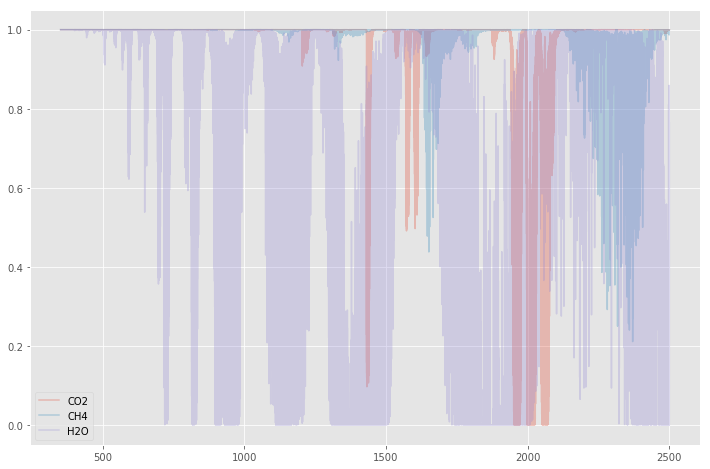

In [25]:

plt.plot(wl_hr, np.exp(-vcd_co2*cs_co2_wl) , alpha=0.3, label="CO2" )
plt.plot(wl_hr, np.exp(-vcd_ch4*cs_ch4_wl) , alpha=0.3, label="CH4" )
plt.plot(wl_hr, np.exp(-vcd_h2o*cs_h2o_wl), alpha=0.3, label="H2O" )
plt.legend(loc=0)

In [15]:

# Import a Gaussian convolution
from scipy.ndimage.filters import gaussian_filter1d
# Import a 1D interpolation routine
from scipy.interpolate import interp1d

# write a separate function to just apply the instrument function (as we do this often:) 
# This could be more sophisticated than a Gaussian line-shape. 
# If we have it in a separate function, things can be easily replaced.
def applyAVng(F):
    co = 2.355
    res = 0.01
    FWHM = 5
    F2 = gaussian_filter1d(F, FWHM/res/co)
    finter = interp1d(wl_hr, F2,kind='linear')
    return finter(wl_lr)
    

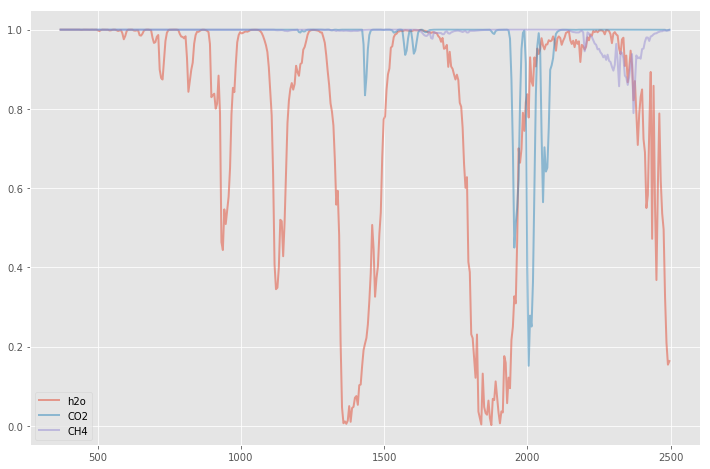

In [26]:
plt.plot(wl_lr, applyAVng(np.exp(-vcd_h2o*cs_h2o_wl)),  alpha=0.5, lw=2, label="h2o" )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_co2*cs_co2_wl)), alpha=0.5, lw=2, label="CO2" )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_ch4*cs_ch4_wl)), alpha=0.5, lw=2, label="CH4" )
plt.legend(loc=0)

In [30]:
Th2o = np.exp(-vcd_h2o*cs_h2o_wl)
Tco2 = np.exp(-vcd_co2*cs_co2_wl)
Tch4 = np.exp(-vcd_ch4*cs_ch4_wl)
Tdch4 = np.exp(-1e18*cs_ch4_wl)

(2000, 2500)

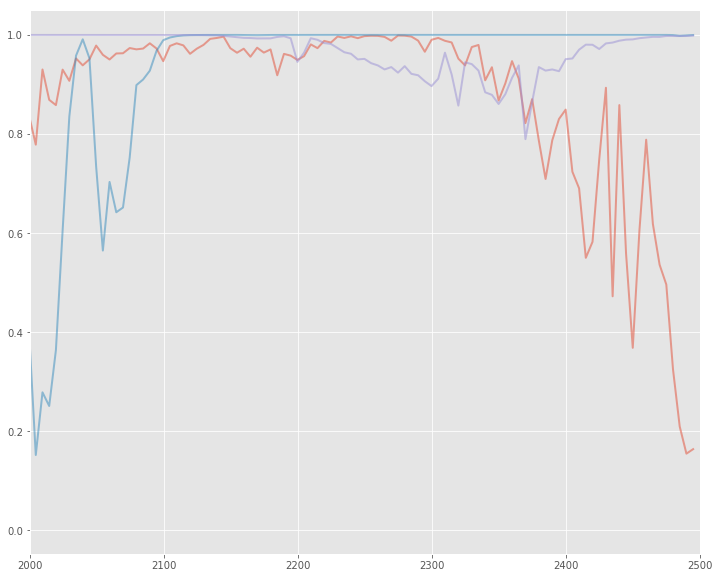

In [19]:
plt.plot(wl_lr, applyAVng(np.exp(-vcd_h2o*cs_h2o_wl)), alpha=0.5, lw=2 )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_co2*cs_co2_wl)), alpha=0.5, lw=2 )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_ch4*cs_ch4_wl)), alpha=0.5, lw=2 )
plt.xlim((2000,2500))

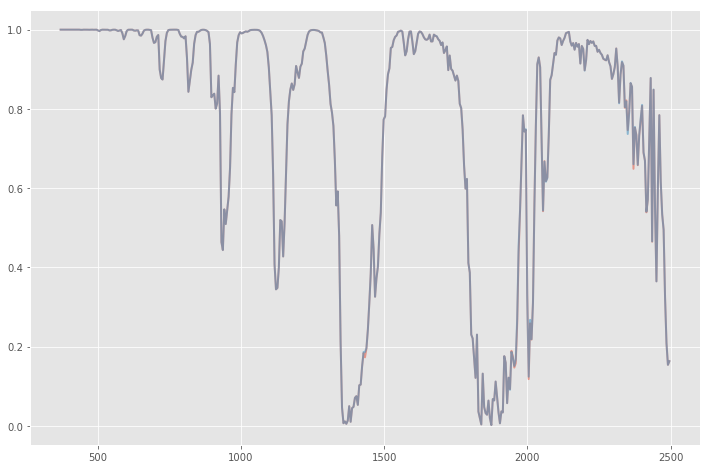

In [29]:
plt.plot(wl_lr, applyAVng(Th2o)*applyAVng(Tco2)*applyAVng(Tch4), alpha=0.5, lw=2 )
plt.plot(wl_lr, applyAVng(Th2o*Tco2*Tch4), alpha=0.5, lw=2 )

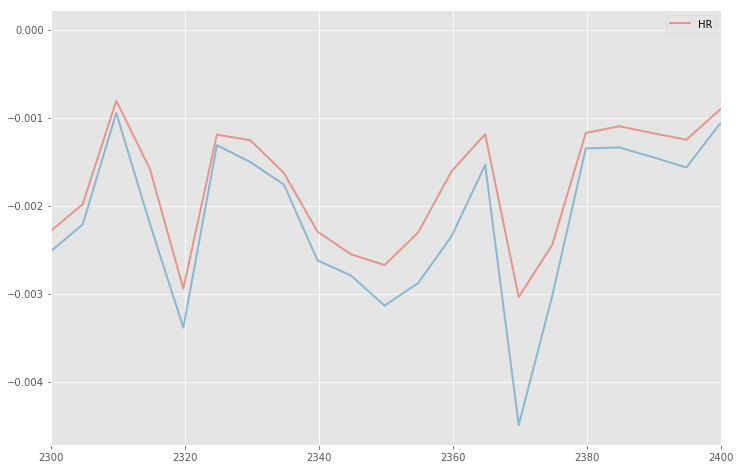

In [76]:
plt.plot(wl_lr, applyAVng(Th2o*Tco2*Tch4*Tdch4)-applyAVng(Th2o*Tco2*Tch4), alpha=0.5, lw=2, label="HR" )
plt.plot(wl_lr, applyAVng(Th2o)*applyAVng(Tco2)*applyAVng(Tch4)*applyAVng(Tdch4)-applyAVng(Th2o)*applyAVng(Tco2)*applyAVng(Tch4), alpha=0.5, lw=2 )
plt.xlim((2300,2400))
plt.legend()

In [53]:
ins  = [370]
out = [369,372]


In [54]:
m_in = img[:,:,ins]
m_out = (img[:,:,369]+img[:,:,372])/2

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-55965.90234375, 8805.0087890625]
    G: [-55965.90234375, 8805.0087890625]
    B: [-55965.90234375, 8805.0087890625]

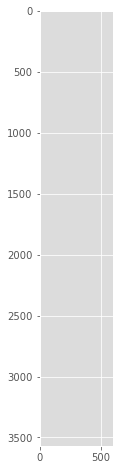

In [60]:
imshow(m_in/m_out)

In [61]:
ratio = m_in/m_out


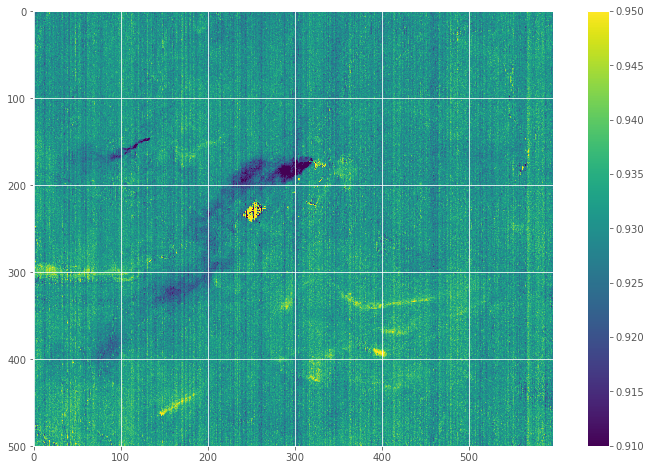

In [75]:
plt.imshow(ratio[2000:2500,:,0],vmin=0.91, vmax=0.95)
plt.colorbar()


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [1.6666837930679321, 21.140193939208984]
    G: [2.3785924911499023, 18.134843826293945]
    B: [2.1339809894561768, 20.632106781005859]

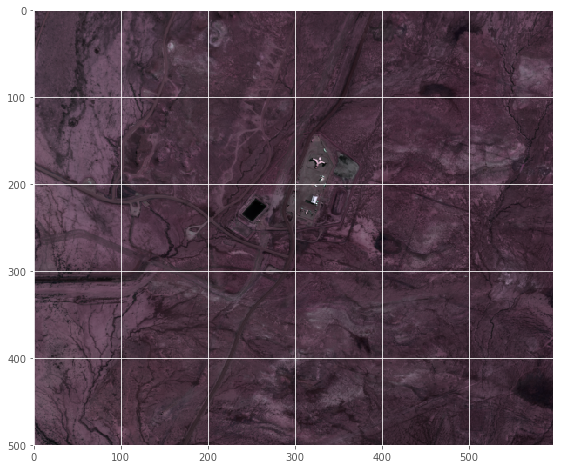

In [89]:
imshow(rgb[2000:2500,:,:])

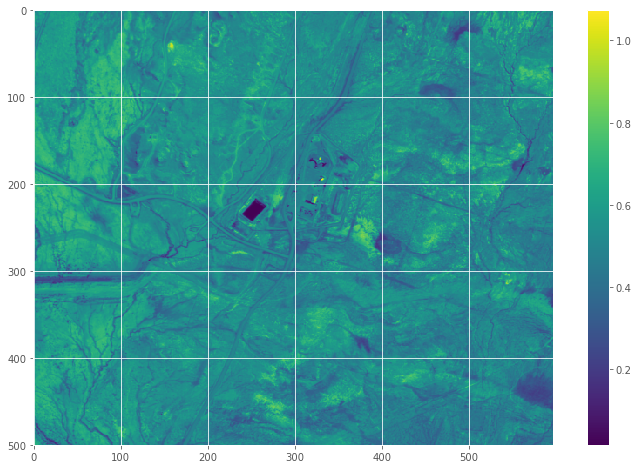

In [90]:
plt.imshow(m_in[2000:2500,:,0])
plt.colorbar()